# Validation

![](images/hair.png)

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

In [3]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

## PART 1: Reading in and sampling from the data

In [4]:
df=pd.read_csv("data/noisypopulation.csv")
df.head()

,f,x,y
0,0.047790,0.00,0.011307
1,0.051199,0.01,0.010000
2,0.054799,0.02,0.007237
3,0.058596,0.03,0.000056
4,0.062597,0.04,0.010000


In [5]:
f=df.f.values
x=df.x.values
y = df.y.values

In [6]:
df.shape

(200, 3)

From 200 points on this curve, we'll make a random choice of 60 points. We do it by choosing the indexes randomly, and then using these indexes as a way of grtting the appropriate samples

In [7]:
indexes=np.sort(np.random.choice(x.shape[0], size=60, replace=False))
indexes

array([  5,   9,  10,  13,  15,  16,  24,  26,  28,  32,  34,  36,  40,
        50,  51,  58,  61,  63,  67,  68,  71,  73,  83,  85, 101, 108,
       110, 112, 113, 117, 122, 126, 127, 129, 134, 140, 142, 143, 145,
       155, 156, 157, 160, 161, 163, 164, 169, 173, 175, 176, 177, 178,
       182, 184, 186, 187, 190, 192, 194, 197])

In [8]:
samplex = x[indexes]
samplef = f[indexes]
sampley = y[indexes]

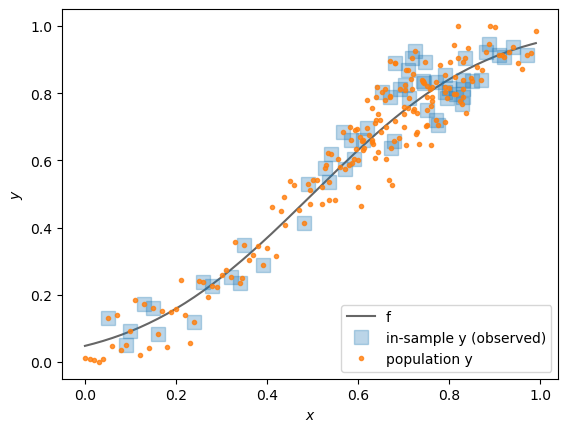

In [9]:
plt.plot(x,f, 'k-', alpha=0.6, label="f");
plt.plot(x[indexes], y[indexes], 's', alpha=0.3, ms=10, label="in-sample y (observed)");
plt.plot(x, y, '.', alpha=0.8, label="population y");
plt.xlabel('$x$');
plt.ylabel('$y$')
plt.legend(loc=4);

In [10]:
sample_df=pd.DataFrame(dict(x=x[indexes],f=f[indexes],y=y[indexes]))

In [11]:
sample_df.head()

,x,f,y
0,0.05,0.066807,0.130963
1,0.09,0.085865,0.050510
2,0.10,0.091211,0.090796
3,0.13,0.108726,0.171233
4,0.15,0.121673,0.160234


## Part 2: Fit on training set and predict on test set

### Train-test split

In [12]:
from sklearn.model_selection import train_test_split

Use train_test_split to get your X_train, X_test and corresponding response vectors from samplex and sampley. Use a train size of 80% in the training set and 20% in the test set

In [15]:
train_test_split?

In [13]:
# your code here
#train_test_split?
X_train, X_test, y_train, y_test = train_test_split(samplex, sampley, train_size=0.8 )

In [14]:
print(y_train.shape)

(48,)


We'll need to create polynomial features, ie add 1, x, x^2 and so on.

### The `scikit-learn` interface

Scikit-learn is the main python machine learning library. It consists of many learners which can learn models from data, as well as a lot of utility functions such as `train_test_split`. It can be used in python by the incantation `import sklearn`.

The library has a very well defined interface. This makes the library a joy to use, and surely contributes to its popularity. As the [scikit-learn API paper](http://arxiv.org/pdf/1309.0238v1.pdf) [Buitinck, Lars, et al. "API design for machine learning software: experiences from the scikit-learn project." arXiv preprint arXiv:1309.0238 (2013).] says:

>All objects within scikit-learn share a uniform common basic API consisting of three complementary interfaces: **an estimator interface for building and ﬁtting models, a predictor interface for making predictions and a transformer interface for converting data**. The estimator interface is at the core of the library. It deﬁnes instantiation mechanisms of objects and exposes a `fit` method for learning a model from training data. All supervised and unsupervised learning algorithms (e.g., for classiﬁcation, regression or clustering) are oﬀered as objects implementing this interface. Machine learning tasks like feature extraction, feature selection or dimensionality reduction are also provided as estimators.

We'll use the "estimator" interface here, specifically the estimator `PolynomialFeatures`. The API paper again:

>Since it is common to modify or ﬁlter data before feeding it to a learning algorithm, some estimators in the library implement a transformer interface which deﬁnes a transform method. It takes as input some new data X and yields as output a transformed version of X. Preprocessing, feature selection, feature extraction and dimensionality reduction algorithms are all provided as transformers within the library.

To start with we have one **feature** `x` to predict `y`, what we will do is the transformation:

$$ x \rightarrow 1, x, x^2, x^3, ..., x^d $$

for some power $d$. Our job then is to **fit** for the coefficients of these features in the polynomial

$$ a_0 + a_1 x + a_2 x^2 + ... + a_d x^d. $$

In other words, we have transformed a function of one feature, into a (rather simple) **linear** function of many features. To do this we first construct the estimator as `PolynomialFeatures(d)`, and then transform these features into a d-dimensional space using the method `fit_transform`.

![fit_transform](images/sklearntrans.jpg)

Here is an example. The reason for using `[[1],[2],[3]]` as opposed to `[1,2,3]` is that scikit-learn expects data to be stored in a two-dimensional array or matrix with size `[n_samples, n_features]`.

We saw this last year when building Simple Linear Regression Models

To transform `[1,2,3]` into [[1],[2],[3]] we need to do a reshape.

![reshape](images/reshape.jpg)

In [15]:
demo = np.array([1,2,3])

In [16]:
demo

array([1, 2, 3])

In [17]:
PolynomialFeatures(3).fit(demo)

NameError: name 'PolynomialFeatures' is not defined

In [18]:
demo = np.array([1,2,3]).reshape(-1,1)

In [19]:
demo

array([[1],
       [2],
       [3]])

Similarly

In [20]:
X_test.reshape(-1,1)

array([[0.77      ],
       [0.74699252],
       [0.15      ],
       [0.13      ],
       [0.65210195],
       [0.69278797],
       [0.54      ],
       [0.81523718],
       [0.83021363],
       [0.97      ],
       [0.83336302],
       [0.70336931]])

Now as said in the "lecture" part, we can use Polynomial Features to make a Polynomial Regression problem. As an example here is [[1,2,3]] going to the power 5

i.e. $x \rightarrow x^0, x^1, x^2, x^3, x^4, x^5$

In [21]:
from sklearn.preprocessing import PolynomialFeatures

In [22]:
a = PolynomialFeatures(5).fit(demo)

In [23]:
a.transform(demo)

array([[  1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.,  16.,  32.],
       [  1.,   3.,   9.,  27.,  81., 243.]])

In [24]:
PolynomialFeatures(5).fit_transform(demo)

array([[  1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   2.,   4.,   8.,  16.,  32.],
       [  1.,   3.,   9.,  27.,  81., 243.]])

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Try PolynomialFeatures(3) with our training set and Test set

In [26]:
# your code here
PolynomialFeatures(3).fit_transform(X_test.reshape(-1,1))

array([[1.        , 0.77      , 0.5929    , 0.456533  ],
       [1.        , 0.74699252, 0.55799782, 0.4168202 ],
       [1.        , 0.15      , 0.0225    , 0.003375  ],
       [1.        , 0.13      , 0.0169    , 0.002197  ],
       [1.        , 0.65210195, 0.42523695, 0.27729785],
       [1.        , 0.69278797, 0.47995517, 0.33250717],
       [1.        , 0.54      , 0.2916    , 0.157464  ],
       [1.        , 0.81523718, 0.66461166, 0.54181614],
       [1.        , 0.83021363, 0.68925467, 0.57222862],
       [1.        , 0.97      , 0.9409    , 0.912673  ],
       [1.        , 0.83336302, 0.69449392, 0.57876555],
       [1.        , 0.70336931, 0.49472838, 0.34797676]])

In [27]:
PolynomialFeatures(3).fit_transform(X_test.reshape(-1,1))

array([[1.        , 0.77      , 0.5929    , 0.456533  ],
       [1.        , 0.74699252, 0.55799782, 0.4168202 ],
       [1.        , 0.15      , 0.0225    , 0.003375  ],
       [1.        , 0.13      , 0.0169    , 0.002197  ],
       [1.        , 0.65210195, 0.42523695, 0.27729785],
       [1.        , 0.69278797, 0.47995517, 0.33250717],
       [1.        , 0.54      , 0.2916    , 0.157464  ],
       [1.        , 0.81523718, 0.66461166, 0.54181614],
       [1.        , 0.83021363, 0.68925467, 0.57222862],
       [1.        , 0.97      , 0.9409    , 0.912673  ],
       [1.        , 0.83336302, 0.69449392, 0.57876555],
       [1.        , 0.70336931, 0.49472838, 0.34797676]])

### Doing the fit

We first create our features, and some arrays to store the errors.

In [28]:
degrees=range(26)

We need empty arrays for each degree
i.e. we will need the room to store values for error_train[0], error_train[1] .... and error_test[0], error_test[1] ...

We are going to use the error_ to store the mean squared error while using score_ to store the r2 score

In [29]:
# fill in gaps and ***
error_train = np.empty(len(degrees))
error_test = np.empty(len(degrees))

In [30]:
score_train = np.zeros(len(degrees))
score_test = np.zeros(len(degrees))

In [31]:
error_train

array([4.67296746e-307, 1.69121096e-306, 1.86920328e-306, 2.22521103e-306,
       1.42419938e-306, 7.56603881e-307, 8.45603440e-307, 7.56587585e-307,
       1.37961302e-306, 1.05699242e-307, 8.01097889e-307, 1.78020169e-306,
       7.56601165e-307, 1.02359984e-306, 1.69118108e-306, 7.56593696e-307,
       1.69118108e-306, 6.89804132e-307, 1.69118923e-306, 8.45559303e-307,
       9.45697982e-308, 1.33511562e-306, 8.90103560e-307, 1.42410974e-306,
       1.00132228e-307, 1.33511969e-306])

What is the fitting process? We first loop over all the **hypothesis set**s that we wish to consider: in our case this is a loop over the complexity parameter $d$, the degree of the polynomials we will try and fit. That is we start with ${\cal H_0}$, the set of all 0th order polynomials, then do ${\cal H_1}$, then ${\cal H_2}$, and so on... We use the notation ${\cal H}$ to indicate a hypothesis set. Then for each degree $d$, we obtain a best fit model. We then "test" this model by predicting on the test chunk, obtaining the test set error for the best-fit polynomial coefficients and for degree $d$. We move on to the next degree $d$ and repeat the process, just like before. We compare all the test set errors, and pick the degree $d_*$ and the model in ${\cal H_{d_*}}$ which minimizes this test set error.

>**YOUR TURN HERE**: For each degree d, train on the training set and predict on the test set. Store the training MSE in `error_train` and test MSE in `error_test`.

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [33]:
#for each degree, we now fit on the training set and predict on the test set
#we accumulate the MSE on both sets in error_train and error_test
#fill in the gaps as usual, look for the comment above
for d in degrees:#for increasing polynomial degrees 0,1,2...
    #print(d)
    # We need to transform our training set and test set by polynomial features of the degree
    X_p_train = PolynomialFeatures(d).fit_transform(X_train.reshape(-1,1))
    X_p_test = PolynomialFeatures(d).fit_transform(X_test.reshape(-1,1))
    #set up model
    est = LinearRegression()
    #fit
    est.fit(X_p_train, y_train)
    #make predictions from the training set and test set, remember use the transformed versions
    prediction_on_training = est.predict(X_p_train)
    prediction_on_test = est.predict(X_p_test)
    #calculate mean squared error and r2 scores
    error_train[d] = mean_squared_error(y_train, prediction_on_training)
    error_test[d] = mean_squared_error(y_test, prediction_on_test)
    score_train[d] = est.score(X_p_train, y_train)
    score_test[d] = est.score(X_p_test, y_test)

We can find the best degree (for the training set) thus:
(argmin to find the index of the lowest mean_squared error, argmax to find the index of the highest R2 score)

In [34]:
error_train

array([0.07355758, 0.00548046, 0.00528037, 0.00392379, 0.00362284,
       0.00346639, 0.00328095, 0.00317458, 0.00302325, 0.00296673,
       0.00295046, 0.00292349, 0.00257581, 0.00257437, 0.00256275,
       0.00252588, 0.00252513, 0.00238413, 0.00236907, 0.00236673,
       0.00236648, 0.00235396, 0.00195287, 0.00193159, 0.00193194,
       0.00193142])

In [35]:
score_train

array([0.        , 0.92549429, 0.92821449, 0.94665689, 0.95074831,
       0.95287511, 0.95539618, 0.95684231, 0.95889954, 0.95966793,
       0.95988917, 0.9602557 , 0.96498242, 0.96500193, 0.96515999,
       0.9656612 , 0.96567135, 0.9675882 , 0.96779295, 0.96782474,
       0.96782823, 0.96799842, 0.97345111, 0.97374043, 0.97373566,
       0.97374276])

In [36]:
np.argmin(error_train)

25

In [37]:
np.argmax(score_train)

25

In [38]:
error_train[15:]

array([0.00252588, 0.00252513, 0.00238413, 0.00236907, 0.00236673,
       0.00236648, 0.00235396, 0.00195287, 0.00193159, 0.00193194,
       0.00193142])

Assign bestd to the lowest value of MSE for test set and bestdscore to the highest value of R2 for the test set

In [39]:
# your code here
bestd = np.argmin(error_test)
bestdscore = np.argmax(score_test)

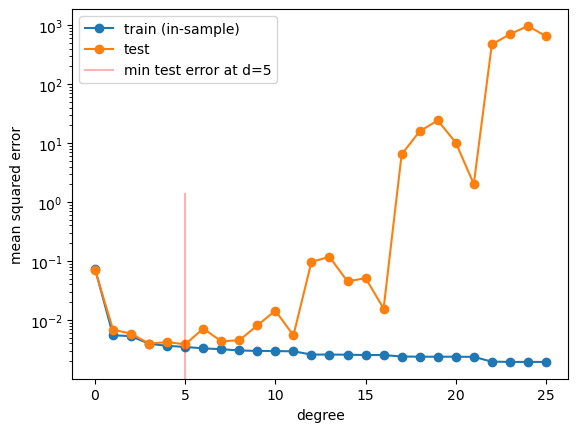

In [40]:
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_test, marker='o', label='test')
plt.axvline(bestd, 0,0.5, color='r', label="min test error at d=%d"%bestd, alpha=0.3)
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")

In [41]:
bestdscore = np.argmax(score_test)

Do a similar plot as above, except this time use the score arrays

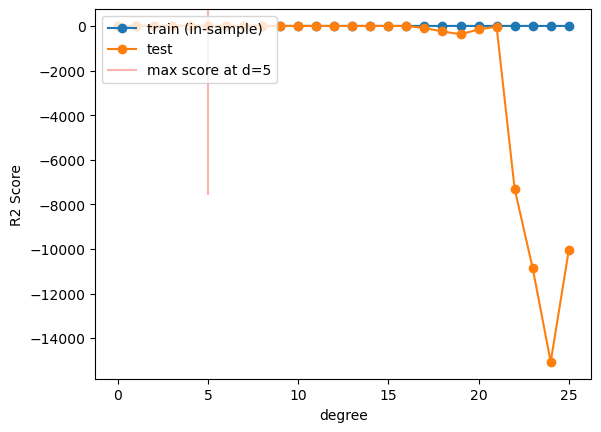

In [42]:
# your code here
plt.plot(degrees, score_train, marker='o', label='train (in-sample)')
plt.plot(degrees, score_test, marker='o', label='test')
plt.axvline(bestd, 0.5,1, color='r', label="max score at d=%d"%bestd, alpha=0.3)
plt.ylabel('R2 Score')
plt.xlabel('degree')
plt.legend(loc='upper left')

You will notice that bestd and bestdscore are the same.

![m:caption](images/complexity-error-plot.png)

## What is wrong with the abo

## Validation

What we have done in picking a given $d$ as the best hypothesis is that we have used the test set as a training set. 
If we choose the best $d$ based on minimizing the test set error, we have then "fit for" hyperparameter $d$ on the test set. 

In this case, the test-set error will underestimate the true out of sample error. Furthermore, we have **contaminated the test set** by fitting for $d$ on it; it is no longer a true test set.

Thus, we introduce a new **validation set** on which the complexity parameter $d$ is fit, and leave out a test set which we can use to estimate the true out-of-sample performance of our learner. The place of this set in the scheme of things is shown below:

![m:caption](images/train-validate-test.png)

We have split the old training set into a **new smaller training set** and a **validation set**, holding the old test aside for FINAL testing AFTER we have "fit" for complexity $d$. Obviously we have decreased the size of the data available for training further, but this is a price we must pay for obtaining a good estimate of the out-of-sample risk $\cal{E}_{out}$ (also denoted as risk $R_{out}$) through the test risk $\cal{E}_{test}$ ($R_{test}$).

![m:caption](images/train-validate-test-cont.png)

The validation process is illustrated in these two figures. We first loop over the complexity parameter $d$, the degree of the polynomials we will try and fit. Then for each degree $d$, we obtain a best fit model $g^-_d$ where the "minus" superscript indicates that we fit our model on the new training set which is obtained by removing ("minusing") a validation chunk (often the same size as the test chunk) from the old training set. We then "test" this model on the validation chunk, obtaining the validation error for the best-fit polynomial coefficients and for degree $d$. We move on to the next degree $d$ and repeat the process, just like before. We compare all the validation set errors, just like we did with the test errors earlier, and pick the degree $d_*$ which minimizes this validation set error.

![caption](images/train-validate-test3.png)

Having picked the hyperparameter $d_*$, we retrain using the hypothesis set $\cal{H}_{*}$ on the entire old training-set to find the parameters of the polynomial of order $d_*$ and the corresponding best fit hypothesis $g_*$. Note that we left the minus off the $g$ to indicate that it was trained on the entire old traing set. We now compute the test error on the test set as an estimate of the test risk $\cal{E}_{test}$.

Thus the **validation** set if the set on which the hyperparameter is fit. This method of splitting the data $\cal{D}$ is called the **train-validate-test** split.

### Fit on training and predict on validation


We carry out this process for one training/validation split below. Note the smaller size of the new training set. We hold the test set at the same size.

Firstly, let's split the training set up further into X_v_train, X_v_valid, y_v_train and y_v_valid using train_test_split again. set test_size to 12

In [45]:
# your code here
X_v_train, X_v_valid, y_v_train, y_v_valid = train_test_split(X_train, y_train, test_size=12)

In [46]:
X_v_train.shape

(36,)

In [47]:
degrees=range(20)


>YOUR TURN HERE: Train on the smaller training set. Fit for d on the validation set.  Store the respective MSEs in `error_train` and `error_valid`. Then retrain on the entire training set using this d. Label the test set MSE with the variable `err`.

In [48]:
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
score_train=np.empty(len(degrees))
score_valid=np.empty(len(degrees))
#for each degree, we now fit on the smaller training set and predict on the validation set
#we accumulate the MSE on both sets in error_train and error_valid
#we then find the degree of polynomial that minimizes the MSE on the validation set.
#your code here
for d in degrees:#for increasing polynomial degrees 0,1,2...
    #Create polynomials from X_v_train and X_v_valid
    X_c = PolynomialFeatures(d).fit_transform(X_v_train.reshape(-1,1))
    X_c_val = PolynomialFeatures(d).fit_transform(X_v_valid.reshape(-1,1))
    #fit a model linear in polynomial coefficients on the new smaller training set
    est = LinearRegression()
    est.fit(X_c, y_v_train)    
    #predict on new training and validation sets and calculate mean squared error
    error_train[d] = mean_squared_error(est.predict(X_c), y_v_train)
    error_valid[d] = mean_squared_error(est.predict(X_c_val), y_v_valid)
    score_train[d] = est.score(X_c, y_v_train)
    score_valid[d] = est.score(X_c_val, y_v_valid)
    

In [49]:
#calculate the degree at which validation error is minimized
mindeg = np.argmin(error_valid)
mindeg

1

verify you get the same result from score_train

In [50]:
maxdeg = np.argmax(score_valid)
maxdeg

1

In [51]:
# ch

In [52]:
#fit on WHOLE training set now. 
##you will need to remake polynomial features on the whole training set
#Put MSE on the test set in variable err.
#your code here
X_p_train = PolynomialFeatures(mindeg).fit_transform(X_train.reshape(-1,1))
X_p_test = PolynomialFeatures(mindeg).fit_transform(X_test.reshape(-1,1))
est = LinearRegression()
est.fit(X_p_train, y_train) # fit
#predict on the test set now and calculate error
pred = est.predict(X_p_test)
err = mean_squared_error(y_test, pred)
score = est.score(X_p_test, y_test)

In [53]:
err

0.008063271214083704

In [54]:
score

0.9237197325035711

We plot the training error and validation error against the degree of the polynomial, and show the test set error at the $d$ which minimizes the validation set error.

1


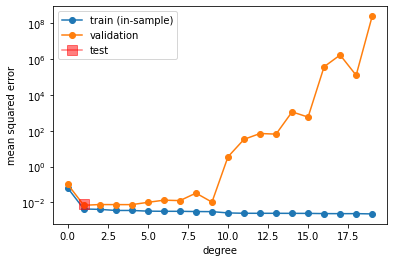

In [55]:
# your code here

plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='o', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")
print(mindeg)

Run the set of cells for the validation process again and again. What do you see? The validation error minimizing polynomial degree might change! What happened?


## Cross Validation

1. You should worry that a given split exposes us to the peculiarity of the data set that got randomly chosen for us. This naturally leads us to want to choose multiple such random splits and somehow average over this process to find the "best" validation minimizing polynomial degree or complexity $d$.
2. The multiple splits process also allows us to get an estimate of how consistent our prediction error is: in other words, just like in the hair example, it gives us a distribution.
3. Furthermore the validation set that we left out has two competing demands on it. The larger the set is, the better is our estimate of the out-of-sample error. So we'd like to hold out as much as possible. But the smaller the validation set is, the more data we have to train our model on. This allows us to have more smaller sets

The idea is illustrated in the figure below, for a given hypothesis set $\cal{H}_a$ with complexity parameter $d=a$ (the polynomial degree). We do the train/validate split, not once but multiple times. 

In the figure below we create 4-folds from the training set part of our data set $\cal{D}$. By this we mean that we divide our set roughly into 4 equal parts. As illustrated below, this can be done in 4 different ways, or folds. In each fold we train a model on 3 of the parts. The model so trained is denoted as $g^-_{Fi}$, for example $g^-_{F3}$ . The minus sign in the superscript once again indicates that we are training on a reduced set. The $F3$ indicates that this model was trained on the third fold. Note that the model trained on each fold will be different!

For each fold, after training the model, we calculate the risk or error on the remaining one validation part. We then add the validation errors together from the different folds, and divide by the number of folds to calculate an average error. Note again that this average error is an average over different models $g^-_{Fi}$. We use this error as the validation error for $d=a$ in the validation process described earlier.

![m:caption](images/train-cv2.png)

Note that the number of folds is equal to the number of splits in the data. For example, if we have 5 splits, there will be 5 folds. To illustrate cross-validation consider below fits in $\cal{H}_0$ and $\cal{H}_1$ (means and straight lines) to a sine curve, with only 3 data points.

### The entire description of K-fold Cross-validation

We put thogether this scheme to calculate the error for a given polynomial degree $d$ with the method we used earlier to choose a model given the validation-set risk as a function of $d$:

1. create `n_folds` partitions of the training data. 
2. We then train on `n_folds -1` of these partitions, and test on the remaining partition. There are `n_folds` such combinations of partitions (or folds), and thus we obtain `n_fold` risks.
3. We average the error or risk of all such combinations to obtain, for each value of $d$, $R_{dCV}$.
4. We move on to the next value of $d$, and repeat 3
5. and then find the optimal value of d that minimizes risk $d=*$.
5. We finally use that value to make the final fit in $\cal{H}_*$ on the entire old training set.

![caption](images/train-cv3.png)

It can also shown that **cross-validation error is an unbiased estimate of the out of sample-error**.

Let us now do 4-fold cross-validation on our  data set. We increase the complexity from degree 0 to degree 20. In each case we take the old training set, split in 4 ways into 4 folds, train on 3 folds, and calculate the validation error on the remaining one. We then average the erros over the four folds to get a cross-validation error for that $d$. Then we did what we did before: find the hypothesis space $\cal{H}_*$ with the lowest cross-validation error, and refit it using the entire training set. We can then use the test set to estimate $E_{out}$.

We will use `KFold` from `scikit-learn`:

In [56]:
from sklearn.model_selection import KFold

In [57]:
n_folds=4
kfold = KFold(n_folds)
list(kfold.split(range(48)))

[(array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
         29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47]),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 24, 25, 26, 27, 28,
         29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47]),
  array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47]),
  array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35]),
  array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]))]

What is wrong with the above? Why must we do the below?

In [58]:
kfold = KFold(n_folds, shuffle=True)
list(kfold.split(range(48)))

[(array([ 0,  1,  2,  3,  4,  5,  8, 10, 11, 12, 14, 15, 17, 18, 19, 20, 22,
         23, 25, 26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 43, 44,
         45, 46]),
  array([ 6,  7,  9, 13, 16, 21, 24, 33, 34, 35, 42, 47])),
 (array([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19,
         20, 21, 22, 23, 24, 26, 28, 30, 31, 33, 34, 35, 37, 38, 40, 41, 42,
         45, 47]),
  array([ 0,  4, 18, 25, 27, 29, 32, 36, 39, 43, 44, 46])),
 (array([ 0,  1,  2,  3,  4,  6,  7,  9, 10, 11, 13, 14, 15, 16, 18, 19, 21,
         24, 25, 27, 28, 29, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44,
         46, 47]),
  array([ 5,  8, 12, 17, 20, 22, 23, 26, 30, 37, 38, 45])),
 (array([ 0,  4,  5,  6,  7,  8,  9, 12, 13, 16, 17, 18, 20, 21, 22, 23, 24,
         25, 26, 27, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 44, 45,
         46, 47]),
  array([ 1,  2,  3, 10, 11, 14, 15, 19, 28, 31, 40, 41]))]

### 4-fold CV on our data set

>YOUR TURN HERE: Carry out 4-Fold validation. For each fold, you will need to first create the polynomial features. for each degree polynomial, fit on the smaller training set and predict on the validation set. Store the MSEs, for each degree and each fold, in `train_errors` and `valid_errors`.

In this case we are going to want train_errors to store results for all the degrees, and each degree is going to have 4 folds.

So we want a 2 dimensional array of len(degrees,n_folds)

In [59]:
n_folds=4
degrees=range(21)
train_errors = np.zeros((len(degrees),n_folds))
valid_errors = np.zeros((len(degrees),n_folds))

In [60]:
# your code here
fold = 0
kf = KFold(n_splits=n_folds, shuffle=True)
for train_index, val_index in kf.split(X_train):
    # We split the training set up based on the index found in kf.split, this allows us to get all the results for one fold
    X_c, X_val = X_train[train_index], X_train[val_index]
    y_c, y_val = y_train[train_index], y_train[val_index]
    for d in degrees:
        # Make the polynomial features
        X_p_c = PolynomialFeatures(d).fit_transform(X_c.reshape(-1,1))
        X_p_val = PolynomialFeatures(d).fit_transform(X_val.reshape(-1,1))
        # base model
        est = LinearRegression()
        est.fit(X_p_c, y_c) # fit on the remaining train
        train_errors[d, fold] = mean_squared_error(est.predict(X_p_c),y_c) 
        valid_errors[d, fold] = mean_squared_error(est.predict(X_p_val),y_val) # evaluate score function on held-out data
    fold += 1

# We could loop the other way around too

this would be how I described it in the lecture

The answers are different, due to kFold being shuffle=True

In [69]:
# your code here

kf = KFold(n_splits=n_folds, shuffle=True)
for d in degrees:
    # We split the training set up based on the index found in kf.split, this allows us to get all the results for one fold
    fold = 0
    for train_index, val_index in kf.split(X_train):
        X_c, X_val = X_train[train_index], X_train[val_index]
        y_c, y_val = y_train[train_index], y_train[val_index]
        # Make the polynomial features
        X_p_c = PolynomialFeatures(d).fit_transform(X_c.reshape(-1,1))
        X_p_val = PolynomialFeatures(d).fit_transform(X_val.reshape(-1,1))
        # base model
        est = LinearRegression()
        est.fit(X_p_c, y_c) # fit on the remaining train
        train_errors[d, fold] = mean_squared_error(est.predict(X_p_c),y_c) 
        valid_errors[d, fold] = mean_squared_error(est.predict(X_p_val),y_val) # evaluate score function on held-out data
    fold += 1

In [70]:
valid_errors

array([[9.18446398e-02, 6.12917163e-02, 7.07029455e-02, 9.06118146e-02],
       [2.91996465e-03, 3.89867522e-03, 7.26100640e-03, 3.69828700e-03],
       [4.28219779e-03, 3.79216031e-03, 7.31612668e-03, 3.78089375e-03],
       [2.67744284e-03, 2.85355292e-03, 5.97998499e-03, 3.93894591e-03],
       [5.58490099e-03, 2.85131919e-03, 6.65333315e-03, 3.97140623e-03],
       [4.52906650e-03, 2.80142203e-03, 6.61029521e-03, 3.94821803e-03],
       [5.83312707e-03, 2.79199781e-03, 9.10151288e-03, 5.40075784e-03],
       [7.28705704e-03, 3.05050398e-03, 1.40012516e-02, 7.05150186e-03],
       [3.25772648e-03, 3.19552280e-03, 2.46491043e-02, 5.81777271e-03],
       [9.39149550e-03, 3.06124020e-03, 1.31631405e-02, 1.60187731e-02],
       [3.20984185e+02, 3.19995215e-03, 9.16259508e-02, 9.62852683e-02],
       [6.53302910e+03, 2.96024639e-03, 1.50080332e+00, 1.28610869e-02],
       [1.13498399e-02, 3.08112345e-03, 4.96955364e+01, 1.05627856e-02],
       [1.30152262e+03, 1.54102779e-02, 4.15248636e

We average the MSEs over the folds. Each row corresponds to a particular degree, so we wish to get the average error for each row

In [62]:
# fill in after the equals
mean_train_errors = train_errors.mean(axis=1)
mean_valid_errors = valid_errors.mean(axis=1)

In [63]:
mean_valid_errors.shape

(21,)

In [64]:
degrees

range(0, 21)

In [65]:
mean_train_errors

array([0.07154636, 0.00482948, 0.00476537, 0.00430054, 0.00425553,
       0.00421419, 0.00411973, 0.00407853, 0.00405212, 0.00396768,
       0.00395012, 0.00387709, 0.00372937, 0.00353346, 0.00350095,
       0.00335917, 0.00329596, 0.00315225, 0.00311654, 0.00304718,
       0.00305271])

In [66]:
std_train_errors = train_errors.std(axis=1)
std_valid_errors = valid_errors.std(axis=1)

We find the degree that minimizes the `cross-validation` error, and just like before, refit the model on the entire training set

In [67]:
import seaborn as sns

3


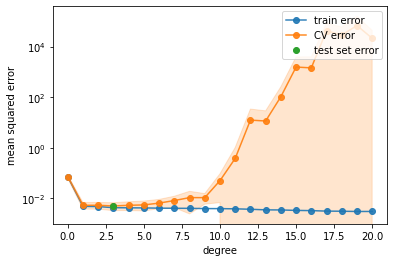

In [68]:
mindeg = np.argmin(mean_valid_errors)
print(mindeg)
#post_cv_train_dict, test_dict=make_features(X_train, X_test, degrees)
#fit on whole training set now.
X_p_train = PolynomialFeatures(mindeg).fit_transform(X_train.reshape(-1,1))
X_p_test = PolynomialFeatures(mindeg).fit_transform(X_test.reshape(-1,1))
est = LinearRegression()
est.fit(X_p_train, y_train) # fit
pred = est.predict(X_p_test)
err = mean_squared_error(pred, y_test)
errtr=mean_squared_error(y_train, est.predict(X_p_train))
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
#plt.errorbar(degrees, [r[0] for r in results], yerr=[r[3] for r in results], marker='o', label='CV error', alpha=0.5)
plt.plot(degrees, mean_train_errors, marker='o', label='train error', alpha=0.9)
plt.plot(degrees, mean_valid_errors, marker='o', label='CV error', alpha=0.9)


plt.fill_between(degrees, mean_valid_errors-std_valid_errors, mean_valid_errors+std_valid_errors, color=c1, alpha=0.2)


plt.plot([mindeg], [err], 'o',  label='test set error')

plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper right')
plt.yscale("log")

We see that the cross-validation error minimizes at a low degree, and then increases. Because we have so few data points the spread in fold errors increases as well.